<a href="https://colab.research.google.com/github/KAREN154/PlantPathoDetect-/blob/main/Maize_Model_Efficientnet_%26_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pickle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# Load the drive helper and mount
from google.colab import drive
# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


***
### MODELING
***
With the previous models achieving a threshold of 80% we explored further usage of pretrained CNN architectures to better the accuracy of the model.
The following models were the best models we achieved.
1. Use of EfficientNetV2B0 architecture
2. Use of ResNet50 architecture


***
##### EFFICIENTNETV2B0 DATA AUGMENTATION
***

In [ ]:
#ImageDataGenerator for training with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ImageDataGenerator for validation (without augmentation)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,

)

# ImageDataGenerator for testing (without augmentation)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,

)

# Creating train, validation, and test image flows from data
train_data = train_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Train',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_data = val_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Val',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_data = test_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4394 images belonging to 3 classes.
Found 1216 images belonging to 3 classes.
Found 136 images belonging to 3 classes.


In [ ]:

# Extract class indices from train_data
y_train = train_data.classes

# Compute class weights
cls_wt = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary for class weights
class_weights = {i: cls_wt[i] for i in range(len(cls_wt))}

print(class_weights)

{0: 2.412959912136189, 1: 0.7794926379279759, 2: 0.7676450034940601}


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Enable mixed precision for faster training on supported GPUs
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ImageDataGenerator for training with fewer augmentations
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,  # Reduced rotation
    zoom_range=0.1,     # Reduced zoom
    horizontal_flip=True
)

# ImageDataGenerator for validation and testing (no augmentation)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

# Load the data with smaller target size (64, 64) and increased batch size
train_data = train_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Train',
    target_size=(64, 64),  # Reduced input size
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,  # Increased batch size
    shuffle=True,
    seed=0
)

val_data = val_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Val',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64
)

test_data = test_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

# Load pretrained EfficientNet with smaller input size
pretrained_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False  # Freeze pretrained layers

# Add dense layers with regularization
x = Dense(64, activation='swish', kernel_regularizer=l2(0.0001))(pretrained_model.output)
x = Dense(32, activation='swish', kernel_regularizer=l2(0.0001))(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

# Create the final model
model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

# Compile the model with a faster optimizer
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with fewer epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # Fewer epochs
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Found 4394 images belonging to 3 classes.
Found 1216 images belonging to 3 classes.
Found 136 images belonging to 3 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 842s 12s/step - accuracy: 0.8396 - loss: 0.4495 - val_accuracy: 0.8947 - val_loss: 0.3270
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 375ms/step - accuracy: 0.9422 - loss: 0.1738 - val_accuracy: 0.9128 - val_loss: 0.2300
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 371ms/step - accuracy: 0.9604 - loss: 0.1372 - val_accuracy: 0.9038 - val_loss: 0.2965
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 370ms/step - accuracy: 0.9653 - loss: 0.1286 - val_accuracy: 0.8906 - val_loss: 0.3563
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.9564 - loss: 0.1335 - val_accuracy: 0.9128 - val_loss: 0.2546
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8934 - loss: 0.3181
Test Loss: 0.2984924614429474, Test Accuracy: 0.9117646813392639



***
##### EFFICIENTNETV2B0 MODEL
***

In [ ]:
# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("TomatoefficientnetV2B0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
# Fitting the model
history1 = model.fit(
    train_data,                 # Training dataset
    validation_data=val_data,   # Validation dataset
    epochs=8,                   # Set number of epochs
    class_weight=class_weights, # Apply class weights if needed
    callbacks=[checkpoint, reduce_lr],  # List of callbacks
    batch_size=None             # Remove batch_size (handled by the dataset object)
)


Epoch 1/8
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9353 - loss: 0.2105
Epoch 1: val_accuracy improved from -inf to 0.92763, saving model to TomatoefficientnetV2B0.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 59s 549ms/step - accuracy: 0.9353 - loss: 0.2104 - val_accuracy: 0.9276 - val_loss: 0.1942 - learning_rate: 0.0010
Epoch 2/8
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9492 - loss: 0.1659
Epoch 2: val_accuracy improved from 0.92763 to 0.93421, saving model to TomatoefficientnetV2B0.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 378ms/step - accuracy: 0.9492 - loss: 0.1660 - val_accuracy: 0.9342 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 3/8
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9512 - loss: 0.1716
Epoch 3: val_accuracy did not improve from 0.93421
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 367ms/step - accuracy: 0.9513 - loss: 0.1715 - val_accuracy: 0.9301 - val_loss: 0.2119 - learning_rate: 0.0010
Epoch 4/8
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9529

In [ ]:
# Evaluating the Validation data
results = model.evaluate(val_data, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.18658
Validation Accuracy: 93.34%


In [ ]:
# Obtain class names from the test data generator
class_names = list(test_data.class_indices.keys())

# Predict on the test data
predictions = model.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_data.classes

# Convert true labels to class names
true_labels_names = [class_names[label] for label in true_labels]

# Convert predicted labels to class names
predicted_labels_names = [class_names[label] for label in predicted_classes]

# Print classification report
print(classification_report(true_labels_names, predicted_labels_names, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.92      0.85      0.89        41
             Healthy       0.94      1.00      0.97        47
Northern Leaf Blight       0.92      0.92      0.92        48

            accuracy                           0.93       136
           macro avg       0.93      0.92      0.92       136
        weighted avg       0.93      0.93      0.93       136



<Figure size 1000x800 with 0 Axes>

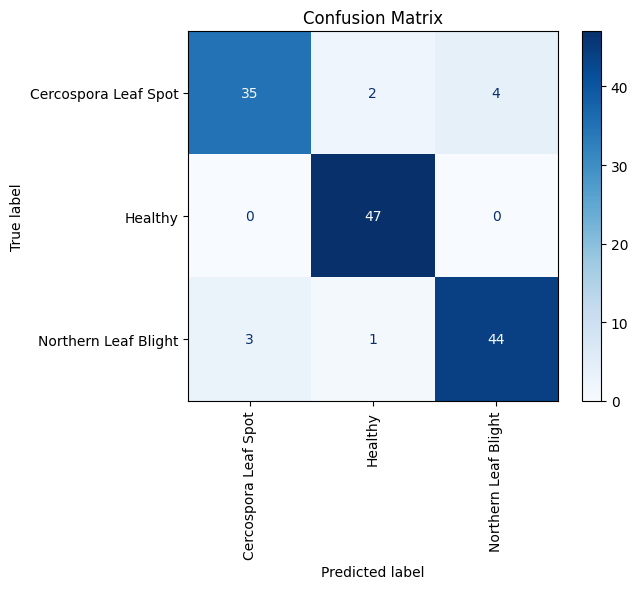

In [ ]:

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes, labels=np.arange(len(class_names)))

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

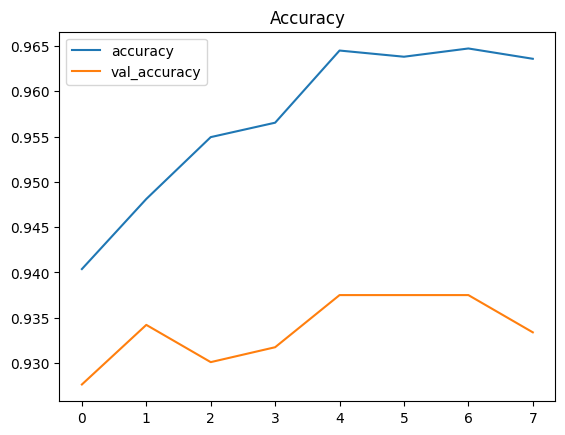

In [ ]:
# Plotting for accuracy in the model
pd.DataFrame(history1.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

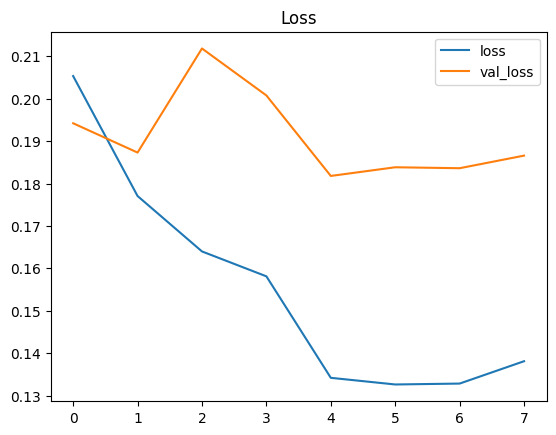

In [ ]:
#Plotting for Loss in the Model
pd.DataFrame(history1.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
import os

# Create the directory if it doesn't exist
os.makedirs('pickle_files/models', exist_ok=True)


# Saving the model into a pickle
with open('pickle_files/models/MaizeefficientnetV2B0.keras', 'wb') as file:
    pickle.dump(model, file)

***
Findings and Observations
***

- This model was able to achieve the desired metrics of of which it achieved 83% accuracy and 83% F1 score.
- The F1 score used was weighted as the classes had been weighted to account for the class imbalance.
- It is evident that classes generalize well to their classes except miscellaneous trash which has an F1 score of 71%.
- The models begin to plateau after 10 epochs in both the accuracy and loss


***
##### RESNET50 DATA AUGMENTATION
***

In [ ]:
# ImageDataGenerator for training with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ImageDataGenerator for validation (without augmentation)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# ImageDataGenerator for testing (without augmentation)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

# Creating train, validation, and test image flows from directories
train_data = train_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Train',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

val_data = val_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Val',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0
)

test_data = test_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4394 images belonging to 3 classes.
Found 1216 images belonging to 3 classes.
Found 136 images belonging to 3 classes.


In [ ]:

# Extract class indices from train_data
y_train = train_data.classes

# Compute class weights
cls_wt = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary for class weights
class_weights = {i: cls_wt[i] for i in range(len(cls_wt))}

print(class_weights)

{0: 2.412959912136189, 1: 0.7794926379279759, 2: 0.7676450034940601}



***
##### RESNET50 MODEL
***

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator objects
train_generator = ImageDataGenerator(rescale=1.0 / 255)
val_generator = ImageDataGenerator(rescale=1.0 / 255)
test_generator = ImageDataGenerator(rescale=1.0 / 255)

# Load the data with the correct target size (64, 64)
train_data = train_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Train',
    target_size=(64, 64),  # Ensure the target size is (64, 64)
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=0
)

val_data = val_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/data/Corn (Maize)/Val',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64
)

test_data = test_generator.flow_from_directory(
    '/content/drive/MyDrive/PlantPathoDetect-/Corn (Maize)/Test',
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

# Ensure the model input shape matches (64, 64, 3)
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the pretrained model with the new input size
pretrained_model = ResNet50(
    input_shape=(64, 64, 3),  # Adjusted input size
    include_top=False,
    weights='imagenet',
    pooling='max'  # Using max pooling for downsampling
)

# Freeze the pretrained layers
pretrained_model.trainable = False

# Add custom layers
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

# Build the model
model = tf.keras.Model(inputs=pretrained_model.input, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    batch_size=64
)


Found 4394 images belonging to 3 classes.
Found 1216 images belonging to 3 classes.
Found 136 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - accuracy: 0.4695 - loss: 0.9999 - val_accuracy: 0.4836 - val_loss: 1.0127
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 299ms/step - accuracy: 0.6234 - loss: 0.8068 - val_accuracy: 0.6127 - val_loss: 0.9350
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.7127 - loss: 0.6814 - val_accuracy: 0.7212 - val_loss: 0.7743
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.7414 - loss: 0.6222 - val_accuracy: 0.7484 - val_loss: 0.7014
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 308ms/step - accuracy: 0.8204 - loss: 0.4981 - val_accuracy: 0.7887 - val_loss: 0.5877
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 298ms/step - accuracy: 0.8304 - loss: 0.4770 - val_accuracy: 0.8117 - val_loss: 0.5463
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/st

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint("resnet50.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
results = model.evaluate(val_data, verbose=0)

print("    Validation Loss: {:.5f}".format(results[0]))
print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    Validation Loss: 0.51935
Validation Accuracy: 82.89%


In [ ]:
# Obtain class names from the test data generator
class_names = list(test_data.class_indices.keys())

# Predict on the test data
predictions = model.predict(test_data, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_data.classes

# Convert true labels to class names
true_labels_names = [class_names[label] for label in true_labels]

# Convert predicted labels to class names
predicted_labels_names = [class_names[label] for label in predicted_classes]

# Print classification report
print(classification_report(true_labels_names, predicted_labels_names, target_names=class_names))


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
                      precision    recall  f1-score   support

Cercospora Leaf Spot       0.96      0.59      0.73        41
             Healthy       0.81      0.94      0.87        47
Northern Leaf Blight       0.75      0.90      0.82        48

            accuracy                           0.82       136
           macro avg       0.84      0.81      0.81       136
        weighted avg       0.84      0.82      0.81       136



<Figure size 1000x800 with 0 Axes>

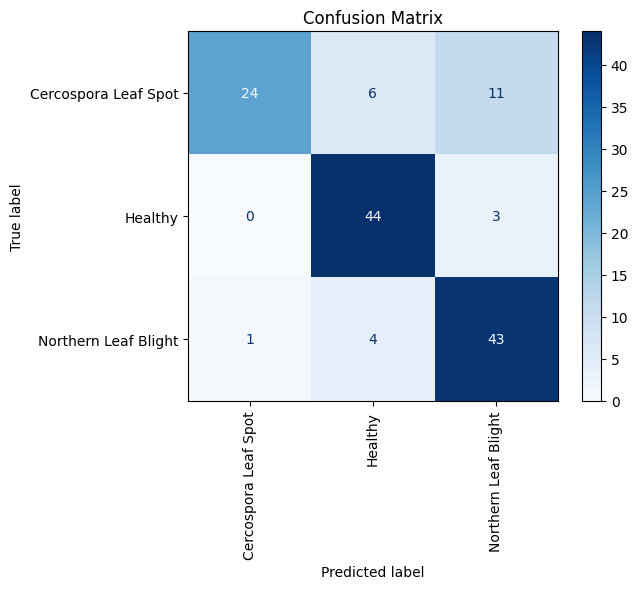

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes, labels=np.arange(len(class_names)))

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Saving the model into a pickle
with open('/content/Maizeresnet50.pkl', 'wb') as file:
    pickle.dump(model, file)


***
Findings and Observations
***
- ResNet50 CNN architecture was able to give us the best model with an accuracy of 85% and an F1 score of 85%
- The F1 score used was weighted as the classes had been weighted to account for the class imbalance.
- Plastics classification was greatly improved to 83% while most of the other models remianed constant or showed better improvement